# Introduction

This colab facilitates reading the Google Runoff Reanalysis & Reforecast dataset (GRRR). The dataset consists of hydrologic predictions by Google's SOTA hydrologic model, an improved version of the model described in the recent [Nature publication](https://www.nature.com/articles/s41586-024-07145-1), with full global coverage (based on the HydroBasins dataset) in daily resolution.

It includes:
*   Streamflow reanalysis for over 1M hybas locations, for 1980-2023.
*   Streamflow reforecasts for over 1M hybas locations, for 2016-2022, with lead-times 0 to 7 days.
*   Return period values based on the reanalysis data, which can be used as severity threshold levels.

The dataset is available under a CC-BY-4.0 license: https://creativecommons.org/licenses/by/4.0/

## Indexing
The dataset is indexed by "gauge_id", which refers to a specific HydroSheds basin (representing *all* area that drains to the basins outlet, and not just the sub-basin area).

For each basin, the reanalysis includes a time series (indexed by "time"). The time T refers to the average daily streamflow at the outlet of the modeled basin (in the range [T, T+1d]; 1d=one day). In other words, the dataset is "left labeled".

The reforecasts are indexed by "issue_time" and "lead_time". The reforecast at issue-time T should be thought of as the forecast that would be generated at the instant time T (the issue time) by the model, if it had all input information that was available until that moment. More specifically, the model receives CPC and IMERG precipitation estimates that refer to times no later than T, and uses HRES and GraphCast weather forecasts that were issued until time T. We ignore the realistic delay of several hours in obtaining the data which exists in an operational setting.

The "lead_time" index (which is a time-delta of 0, 1, ..., 7 days) refers to the end of the forecasted daily window. So the reforecasted value at issue_time=T, lead-time=L, refers to the daily discharge averaged over the time period [T+L-1d, T+L]. In other words, the lead_time index is "right-labeled".

Following the last definitions, note the following relationship of the reanalysis and reforecast datasets:

Reanalysis[time=T] == Reforecast[time=T+1, lead_time=0]

## Appendix - basin outlets
As an appendix, we include location estimates to the outlet points of the modeled basins. Note that the predictions apply to specific points in rivers, as opposed to many global model approaches where the model output is linked to a pixel of several square kilometers. See more information in the appendix below.

# Setup

In [ ]:
!pip install zarr xarray

In [ ]:
import datetime
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
def open_zarr(path):
  return xr.open_zarr(
      store=path,
      chunks=None,
      storage_options=dict(token='anon')
      )

In [ ]:
base_directory = 'gs://flood-forecasting/hydrologic_predictions/model_id_8583a5c2_v0/'
reforecast_path = os.path.join(base_directory, 'reforecast/streamflow.zarr/')
reanalysis_path = os.path.join(base_directory, 'reanalysis/streamflow.zarr/')
return_periods_path = os.path.join(base_directory, 'return_periods.zarr/')

In [ ]:
reforecast_ds = open_zarr(reforecast_path)
reanalysis_ds = open_zarr(reanalysis_path)
return_periods_ds = open_zarr(return_periods_path)

print(f'{reforecast_ds.sizes = }')
print(f'{reanalysis_ds.sizes = }')
print(f'{return_periods_ds.sizes = }')

reforecast_ds.sizes = Frozen({'gauge_id': 1031646, 'issue_time': 2738, 'lead_time': 8})
reanalysis_ds.sizes = Frozen({'gauge_id': 1031646, 'time': 16063})
return_periods_ds.sizes = Frozen({'gauge_id': 1031646})


# Visualize some hybas_id

In [ ]:
hybas_id = 'hybas_2120476740' # Danube, Vienna
gauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()
gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()
gauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()

In [ ]:
#@title Plotting utils
def add_thresholds(ax, gauge_return_periods_ds, thresholds):
  colors = ('yellow', 'orange', 'red', 'brown', 'black')
  for threshold, color in zip(thresholds, colors):
    ax.axhline(
      y=gauge_return_periods_ds[f'return_period_{threshold}'].item(), color=color, label=f'{threshold} year return period', linestyle='--'
    )

def plot_reanalysis(start_date, end_date, gauge_return_periods_ds, thresholds=('2', '5', '20')):
  fig, ax = plt.subplots(figsize=(30, 6))
  gauge_reanalysis_da = gauge_reanalysis_ds.streamflow.sel(time=slice(start_date, end_date))
  ax.plot(gauge_reanalysis_da.time, gauge_reanalysis_da.values)
  add_thresholds(ax, gauge_return_periods_ds, thresholds)
  plt.legend(loc='upper right')
  plt.show()


def plot_reforecast(issue_time_start_date, issue_time_end_date, gauge_return_periods_ds, thresholds=('2', '5', '20')):
  fig, ax = plt.subplots(figsize=(30, 6))
  # For each issue date, we plot the precipitation forecast as a forecast hair.
  for issue_time in gauge_reforecast_ds.sel(issue_time=slice(issue_time_start_date, issue_time_end_date))['issue_time']:
    issue_time_slice = gauge_reforecast_ds.sel(issue_time=issue_time)

    # Get the date for each lead time.
    lead_time_to_dates = [pd.to_datetime(issue_time.values) + datetime.timedelta(seconds=(lead_time.item() // 10**9)) for lead_time in issue_time_slice['lead_time']]

    # Plot the forecast aligned to the dates.
    ax.plot(lead_time_to_dates, issue_time_slice.streamflow.values)

  add_thresholds(ax, gauge_return_periods_ds, thresholds)
  plt.legend(loc='upper right')
  plt.show()



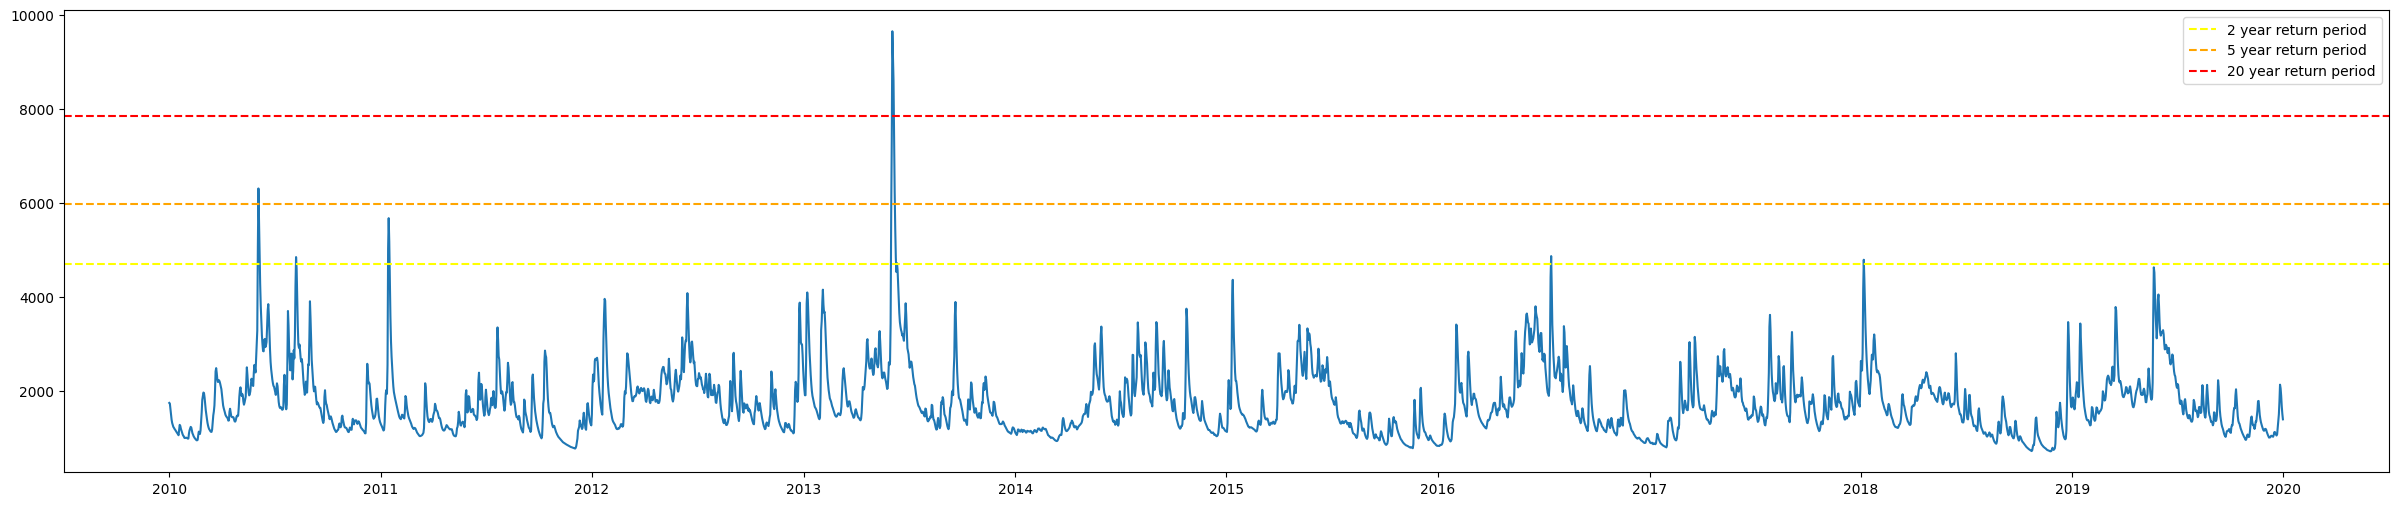

In [ ]:
# Plot REANALYSIS: 1980-2023
start_date = '2010-01-01'
end_date = '2019-12-31'

plot_reanalysis(start_date, end_date, gauge_return_periods_ds)

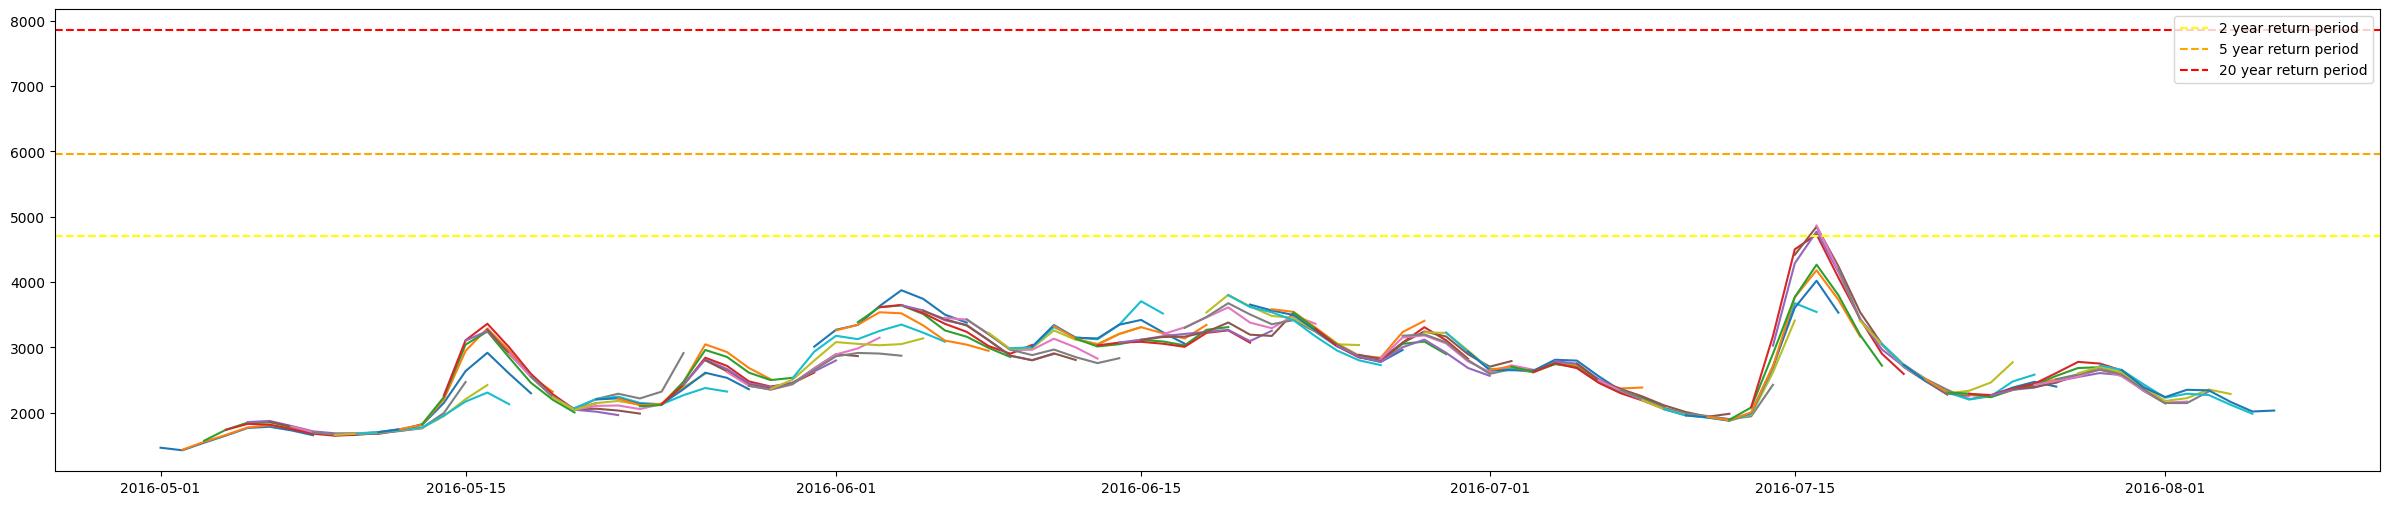

In [ ]:
# Plot REFORECAST: 2016-2023
issue_time_start_date = '2016-05-01'
issue_time_end_date = '2016-07-30'

plot_reforecast(issue_time_start_date, issue_time_end_date, gauge_return_periods_ds)

## Verification of Reanalysis[time=T] == Reforecast[time=T+1, lead_time=0] for some arbitrary time

In [ ]:
gauge_reforecast_ds.sel(issue_time=datetime.datetime(2016, 6, 15)).streamflow.values

array([3112.67  , 3158.037 , 3163.1643, 3234.513 , 3380.1064, 3193.5056,
       3174.1653, 3528.4912], dtype=float32)

In [ ]:
gauge_reanalysis_ds.sel(time=datetime.datetime(2016, 6, 14)).streamflow.item()

3112.669921875

# Appendix - HydroBasins outlet locations

We add a mapping from hybas id to its lat-long location. This data was generated by Prof. Bernhard Lehner, the creator of the HydroSheds dataset, but is not an official part of the dataset as of today (October 2024). We add it as a means to help users of Google's Streamflow dataset find the approximate location for which the predictions apply, which are the outlet points of the respective HydroBasins watershed.

**Important Note** For coastal basins, the outlet is not as well defined as in non-coastal basins. The dataset generated Prof. Lehner includes many possible  outlet points in such cases. For simplicity, we arbitrarily select one of them. Please use those with even more caution, and only as an approximate estimate to the location to the point for which the hydrologic prediction is produced.

In [ ]:
outlets_path = os.path.join(base_directory, 'hybas_outlet_locations_UNOFFICIAL.zarr/')
outlets_ds = open_zarr(outlets_path)

In [ ]:
outlets_ds.sel(gauge_id=hybas_id).compute()

<xarray.Dataset> Size: 80B
Dimensions:    ()
Coordinates:
    gauge_id   <U16 64B 'hybas_2120476740'
Data variables:
    latitude   float64 8B 48.19
    longitude  float64 8B 16.47